# Solución Desafío 1 - Vectorización y Clasificación de Texto
## Dataset: 20 Newsgroups

In [1]:
%pip install numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import f1_score, classification_report
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Carga de Datos

In [3]:
# Cargamos los conjuntos de datos
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

print(f"Documentos de entrenamiento: {len(newsgroups_train.data)}")
print(f"Documentos de test: {len(newsgroups_test.data)}")
print(f"Número de clases: {len(newsgroups_train.target_names)}")
print(f"\nClases: {newsgroups_train.target_names}")

Documentos de entrenamiento: 11314
Documentos de test: 7532
Número de clases: 20

Clases: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


## Punto 1: Vectorización y Análisis de Similaridad de 5 Documentos

Vamos a tomar 5 documentos al azar y analizar los 5 documentos más similares a cada uno.

In [4]:
# Vectorizamos usando TF-IDF
tfidfvect = TfidfVectorizer()
X_train = tfidfvect.fit_transform(newsgroups_train.data)
y_train = newsgroups_train.target

# Creamos diccionario índice a palabra
idx2word = {v: k for k, v in tfidfvect.vocabulary_.items()}

print(f"Forma de la matriz documento-término: {X_train.shape}")
print(f"Cantidad de documentos: {X_train.shape[0]}")
print(f"Tamaño del vocabulario: {X_train.shape[1]}")

Forma de la matriz documento-término: (11314, 101631)
Cantidad de documentos: 11314
Tamaño del vocabulario: 101631


In [5]:
# Seleccionamos 5 documentos al azar con semilla fija para reproducibilidad
np.random.seed(42)
random_indices = np.random.choice(len(newsgroups_train.data), size=5, replace=False)

print("Índices de documentos seleccionados:", random_indices)

Índices de documentos seleccionados: [7492 3546 5582 4793 3813]


In [6]:
def analyze_document_similarity(doc_idx, X, y, data, target_names, top_k=5):
    """
    Analiza la similaridad de un documento con todos los demás.
    """
    # Calculamos similaridad coseno con todos los documentos
    cossim = cosine_similarity(X[doc_idx], X)[0]
    
    # Obtenemos los índices de los documentos más similares (excluyendo el mismo)
    most_similar_indices = np.argsort(cossim)[::-1][1:top_k+1]
    
    print("="*80)
    print(f"\nDOCUMENTO ORIGINAL (índice {doc_idx})")
    print(f"Clase: {target_names[y[doc_idx]]}")
    print(f"Contenido (primeros 500 caracteres):\n{data[doc_idx][:500]}...")
    print("\n" + "-"*80)
    
    print(f"\nTOP {top_k} DOCUMENTOS MÁS SIMILARES:")
    for rank, idx in enumerate(most_similar_indices, 1):
        print(f"\n{rank}. Documento {idx}")
        print(f"   Similaridad: {cossim[idx]:.4f}")
        print(f"   Clase: {target_names[y[idx]]}")
        print(f"   Contenido (primeros 200 caracteres): {data[idx][:200]}...")
    
    # Análisis de clases
    original_class = target_names[y[doc_idx]]
    similar_classes = [target_names[y[idx]] for idx in most_similar_indices]
    same_class_count = sum(1 for c in similar_classes if c == original_class)
    
    print("\n" + "-"*80)
    print(f"ANÁLISIS: {same_class_count}/{top_k} documentos similares pertenecen a la misma clase.")
    
    return cossim, most_similar_indices

In [7]:
# Analizamos cada uno de los 5 documentos seleccionados
for doc_idx in random_indices:
    analyze_document_similarity(
        doc_idx, 
        X_train, 
        y_train, 
        newsgroups_train.data, 
        newsgroups_train.target_names,
        top_k=5
    )


DOCUMENTO ORIGINAL (índice 7492)
Clase: comp.sys.mac.hardware
Contenido (primeros 500 caracteres):
Could someone please post any info on these systems.

Thanks.
BoB
-- 
---------------------------------------------------------------------- 
Robert Novitskey | "Pursuing women is similar to banging one's head
rrn@po.cwru.edu  |  against a wall...with less opportunity for reward" ...

--------------------------------------------------------------------------------

TOP 5 DOCUMENTOS MÁS SIMILARES:

1. Documento 10935
   Similaridad: 0.6665
   Clase: comp.sys.mac.hardware
   Contenido (primeros 200 caracteres): Hey everybody:

   I want to buy a mac and I want to get a good price...who doesn't?  So,
could anyone out there who has found a really good deal on a Centris 650
send me the price.  I don't want to k...

2. Documento 7258
   Similaridad: 0.3476
   Clase: comp.sys.ibm.pc.hardware
   Contenido (primeros 200 caracteres): Hay all:

    Has anyone out there heard of any performance stat

### Interpretación Punto 1

**Análisis de resultados:**

La vectorización TF-IDF captura bien la similaridad temática entre documentos. Los documentos más similares típicamente:
- Pertenecen a la misma categoría o categorías relacionadas
- Comparten vocabulario específico del dominio
- Tratan temas similares aunque puedan diferir en detalles

Las métricas de similaridad coseno más altas (>0.7) generalmente indican documentos muy relacionados, mientras que valores más bajos (0.3-0.5) pueden indicar relaciones temáticas más débiles o vocabulario compartido limitado.

Es interesante notar cómo documentos de categorías aparentemente diferentes pueden tener alta similaridad si comparten vocabulario técnico o temático (por ejemplo, categorías relacionadas con computación).

## Punto 2: Clasificación por Prototipos (Zero-Shot)

Clasificamos documentos del conjunto de test comparando cada uno con todos los de entrenamiento y asignando la clase del documento más similar.

In [8]:
# Vectorizamos el conjunto de test con el vectorizador ya entrenado
X_test = tfidfvect.transform(newsgroups_test.data)
y_test = newsgroups_test.target

print(f"Forma de X_test: {X_test.shape}")
print(f"Cantidad de documentos de test: {X_test.shape[0]}")

Forma de X_test: (7532, 101631)
Cantidad de documentos de test: 7532


In [9]:
def prototype_classification(X_train, y_train, X_test):
    """
    Clasifica documentos de test usando el método de prototipos:
    Cada documento de test se asigna a la clase del documento de train más similar.
    """
    y_pred = []
    
    print("Clasificando documentos...")
    for i in range(X_test.shape[0]):
        if i % 500 == 0:
            print(f"Procesando documento {i}/{X_test.shape[0]}")
        
        # Calculamos similaridad con todos los documentos de train
        similarities = cosine_similarity(X_test[i], X_train)[0]
        
        # Encontramos el documento más similar
        most_similar_idx = np.argmax(similarities)
        
        # Asignamos la clase de ese documento
        y_pred.append(y_train[most_similar_idx])
    
    return np.array(y_pred)

In [10]:
# Realizamos la clasificación por prototipos
y_pred_prototype = prototype_classification(X_train, y_train, X_test)

Clasificando documentos...
Procesando documento 0/7532
Procesando documento 500/7532
Procesando documento 1000/7532
Procesando documento 1500/7532
Procesando documento 2000/7532
Procesando documento 2500/7532
Procesando documento 3000/7532
Procesando documento 3500/7532
Procesando documento 4000/7532
Procesando documento 4500/7532
Procesando documento 5000/7532
Procesando documento 5500/7532
Procesando documento 6000/7532
Procesando documento 6500/7532
Procesando documento 7000/7532
Procesando documento 7500/7532


In [11]:
# Evaluamos el desempeño
f1_macro_prototype = f1_score(y_test, y_pred_prototype, average='macro')
f1_micro_prototype = f1_score(y_test, y_pred_prototype, average='micro')

print("\n" + "="*80)
print("RESULTADOS CLASIFICACIÓN POR PROTOTIPOS")
print("="*80)
print(f"F1-Score Macro: {f1_macro_prototype:.4f}")
print(f"F1-Score Micro (Accuracy): {f1_micro_prototype:.4f}")
print("\nReporte de clasificación:\n")
print(classification_report(y_test, y_pred_prototype, target_names=newsgroups_test.target_names))


RESULTADOS CLASIFICACIÓN POR PROTOTIPOS
F1-Score Macro: 0.5050
F1-Score Micro (Accuracy): 0.5089

Reporte de clasificación:

                          precision    recall  f1-score   support

             alt.atheism       0.37      0.51      0.43       319
           comp.graphics       0.54      0.48      0.51       389
 comp.os.ms-windows.misc       0.51      0.46      0.48       394
comp.sys.ibm.pc.hardware       0.52      0.52      0.52       392
   comp.sys.mac.hardware       0.53      0.50      0.52       385
          comp.windows.x       0.70      0.59      0.64       395
            misc.forsale       0.63      0.46      0.53       390
               rec.autos       0.41      0.58      0.48       396
         rec.motorcycles       0.63      0.52      0.57       398
      rec.sport.baseball       0.65      0.54      0.59       397
        rec.sport.hockey       0.75      0.72      0.73       399
               sci.crypt       0.55      0.59      0.57       396
         sci.el

### Interpretación Punto 2

**Análisis del método de clasificación por prototipos:**

Este método de clasificación zero-shot funciona bajo el principio de que documentos similares pertenecen a la misma clase. 

**Ventajas:**
- Método simple e interpretable
- No requiere entrenamiento de un modelo
- Funciona bien cuando hay documentos muy representativos de cada clase

**Desventajas:**
- Computacionalmente costoso (requiere calcular similaridad con todos los documentos)
- Sensible a outliers en el conjunto de entrenamiento
- No aprovecha información estadística de toda la clase

El desempeño de este método sirve como baseline para comparar con modelos más sofisticados como Naïve Bayes.

## Punto 3: Optimización de Modelos Naïve Bayes

Vamos a experimentar con diferentes configuraciones de vectorizadores y modelos Naïve Bayes para maximizar el F1-score macro.

In [12]:
def evaluate_model(vectorizer, model, train_data, train_labels, test_data, test_labels, config_name):
    """
    Entrena y evalúa un modelo de clasificación.
    """
    # Vectorizamos
    X_train = vectorizer.fit_transform(train_data)
    X_test = vectorizer.transform(test_data)
    
    # Entrenamos
    model.fit(X_train, train_labels)
    
    # Predecimos
    y_pred = model.predict(X_test)
    
    # Evaluamos
    f1_macro = f1_score(test_labels, y_pred, average='macro')
    f1_micro = f1_score(test_labels, y_pred, average='micro')
    
    print(f"\n{'='*80}")
    print(f"Configuración: {config_name}")
    print(f"{'='*80}")
    print(f"Vocabulario: {X_train.shape[1]} términos")
    print(f"F1-Score Macro: {f1_macro:.4f}")
    print(f"F1-Score Micro: {f1_micro:.4f}")
    
    return f1_macro, f1_micro, y_pred

In [13]:
# Diccionario para guardar resultados
results = {}

print("Comenzando experimentación con diferentes configuraciones...\n")

Comenzando experimentación con diferentes configuraciones...



### Experimento 1: TF-IDF básico con MultinomialNB

In [14]:
vectorizer = TfidfVectorizer()
model = MultinomialNB()
f1_macro, f1_micro, _ = evaluate_model(
    vectorizer, model, 
    newsgroups_train.data, y_train,
    newsgroups_test.data, y_test,
    "TF-IDF básico + MultinomialNB"
)
results['tfidf_basic_multinomial'] = f1_macro


Configuración: TF-IDF básico + MultinomialNB
Vocabulario: 101631 términos
F1-Score Macro: 0.5854
F1-Score Micro: 0.6062


### Experimento 2: TF-IDF básico con ComplementNB

In [15]:
vectorizer = TfidfVectorizer()
model = ComplementNB()
f1_macro, f1_micro, _ = evaluate_model(
    vectorizer, model,
    newsgroups_train.data, y_train,
    newsgroups_test.data, y_test,
    "TF-IDF básico + ComplementNB"
)
results['tfidf_basic_complement'] = f1_macro


Configuración: TF-IDF básico + ComplementNB
Vocabulario: 101631 términos
F1-Score Macro: 0.6930
F1-Score Micro: 0.7146


### Experimento 3: TF-IDF con max_df y min_df

In [16]:
# Filtramos términos muy frecuentes (stopwords implícitas) y muy raros (ruido)
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2)
model = MultinomialNB()
f1_macro, f1_micro, _ = evaluate_model(
    vectorizer, model,
    newsgroups_train.data, y_train,
    newsgroups_test.data, y_test,
    "TF-IDF (max_df=0.5, min_df=2) + MultinomialNB"
)
results['tfidf_filtered_multinomial'] = f1_macro


Configuración: TF-IDF (max_df=0.5, min_df=2) + MultinomialNB
Vocabulario: 39414 términos
F1-Score Macro: 0.6121
F1-Score Micro: 0.6381


### Experimento 4: TF-IDF con max_df y min_df + ComplementNB

In [17]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2)
model = ComplementNB()
f1_macro, f1_micro, _ = evaluate_model(
    vectorizer, model,
    newsgroups_train.data, y_train,
    newsgroups_test.data, y_test,
    "TF-IDF (max_df=0.5, min_df=2) + ComplementNB"
)
results['tfidf_filtered_complement'] = f1_macro


Configuración: TF-IDF (max_df=0.5, min_df=2) + ComplementNB
Vocabulario: 39414 términos
F1-Score Macro: 0.6930
F1-Score Micro: 0.7131


### Experimento 5: TF-IDF con sublinear_tf

In [18]:
# sublinear_tf aplica log scaling a las frecuencias de términos
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=2)
model = MultinomialNB()
f1_macro, f1_micro, _ = evaluate_model(
    vectorizer, model,
    newsgroups_train.data, y_train,
    newsgroups_test.data, y_test,
    "TF-IDF (sublinear_tf, max_df=0.5, min_df=2) + MultinomialNB"
)
results['tfidf_sublinear_multinomial'] = f1_macro


Configuración: TF-IDF (sublinear_tf, max_df=0.5, min_df=2) + MultinomialNB
Vocabulario: 39414 términos
F1-Score Macro: 0.6091
F1-Score Micro: 0.6361


### Experimento 6: TF-IDF con sublinear_tf + ComplementNB

In [19]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=2)
model = ComplementNB()
f1_macro, f1_micro, _ = evaluate_model(
    vectorizer, model,
    newsgroups_train.data, y_train,
    newsgroups_test.data, y_test,
    "TF-IDF (sublinear_tf, max_df=0.5, min_df=2) + ComplementNB"
)
results['tfidf_sublinear_complement'] = f1_macro


Configuración: TF-IDF (sublinear_tf, max_df=0.5, min_df=2) + ComplementNB
Vocabulario: 39414 términos
F1-Score Macro: 0.6935
F1-Score Micro: 0.7143


### Experimento 7: CountVectorizer + MultinomialNB

In [20]:
vectorizer = CountVectorizer(max_df=0.5, min_df=2)
model = MultinomialNB()
f1_macro, f1_micro, _ = evaluate_model(
    vectorizer, model,
    newsgroups_train.data, y_train,
    newsgroups_test.data, y_test,
    "CountVectorizer (max_df=0.5, min_df=2) + MultinomialNB"
)
results['count_multinomial'] = f1_macro


Configuración: CountVectorizer (max_df=0.5, min_df=2) + MultinomialNB
Vocabulario: 39414 términos
F1-Score Macro: 0.5969
F1-Score Micro: 0.6287


### Experimento 8: CountVectorizer + ComplementNB

In [21]:
vectorizer = CountVectorizer(max_df=0.5, min_df=2)
model = ComplementNB()
f1_macro, f1_micro, _ = evaluate_model(
    vectorizer, model,
    newsgroups_train.data, y_train,
    newsgroups_test.data, y_test,
    "CountVectorizer (max_df=0.5, min_df=2) + ComplementNB"
)
results['count_complement'] = f1_macro


Configuración: CountVectorizer (max_df=0.5, min_df=2) + ComplementNB
Vocabulario: 39414 términos
F1-Score Macro: 0.6363
F1-Score Micro: 0.6670


### Experimento 9: TF-IDF optimizado con alpha en MultinomialNB

In [22]:
# Probamos diferentes valores de alpha (suavizado de Laplace)
best_alpha = None
best_f1 = 0

for alpha in [0.01, 0.1, 0.5, 1.0, 2.0]:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=2)
    model = MultinomialNB(alpha=alpha)
    f1_macro, f1_micro, _ = evaluate_model(
        vectorizer, model,
        newsgroups_train.data, y_train,
        newsgroups_test.data, y_test,
        f"TF-IDF optimizado + MultinomialNB (alpha={alpha})"
    )
    results[f'tfidf_opt_multinomial_alpha{alpha}'] = f1_macro
    
    if f1_macro > best_f1:
        best_f1 = f1_macro
        best_alpha = alpha

print(f"\nMejor alpha para MultinomialNB: {best_alpha} (F1: {best_f1:.4f})")


Configuración: TF-IDF optimizado + MultinomialNB (alpha=0.01)
Vocabulario: 39414 términos
F1-Score Macro: 0.6740
F1-Score Micro: 0.6905

Configuración: TF-IDF optimizado + MultinomialNB (alpha=0.1)
Vocabulario: 39414 términos
F1-Score Macro: 0.6726
F1-Score Micro: 0.6966

Configuración: TF-IDF optimizado + MultinomialNB (alpha=0.5)
Vocabulario: 39414 términos
F1-Score Macro: 0.6329
F1-Score Micro: 0.6621

Configuración: TF-IDF optimizado + MultinomialNB (alpha=1.0)
Vocabulario: 39414 términos
F1-Score Macro: 0.6091
F1-Score Micro: 0.6361

Configuración: TF-IDF optimizado + MultinomialNB (alpha=2.0)
Vocabulario: 39414 términos
F1-Score Macro: 0.5792
F1-Score Micro: 0.6041

Mejor alpha para MultinomialNB: 0.01 (F1: 0.6740)


### Experimento 10: TF-IDF optimizado con norm en ComplementNB

In [23]:
# ComplementNB con diferentes valores de alpha y norm_weights
for alpha in [0.1, 0.5, 1.0]:
    for norm in [True, False]:
        vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=2)
        model = ComplementNB(alpha=alpha, norm=norm)
        f1_macro, f1_micro, _ = evaluate_model(
            vectorizer, model,
            newsgroups_train.data, y_train,
            newsgroups_test.data, y_test,
            f"TF-IDF optimizado + ComplementNB (alpha={alpha}, norm={norm})"
        )
        results[f'tfidf_opt_complement_alpha{alpha}_norm{norm}'] = f1_macro


Configuración: TF-IDF optimizado + ComplementNB (alpha=0.1, norm=True)
Vocabulario: 39414 términos
F1-Score Macro: 0.6875
F1-Score Micro: 0.7046

Configuración: TF-IDF optimizado + ComplementNB (alpha=0.1, norm=False)
Vocabulario: 39414 términos
F1-Score Macro: 0.6897
F1-Score Micro: 0.7080

Configuración: TF-IDF optimizado + ComplementNB (alpha=0.5, norm=True)
Vocabulario: 39414 términos
F1-Score Macro: 0.6920
F1-Score Micro: 0.7118

Configuración: TF-IDF optimizado + ComplementNB (alpha=0.5, norm=False)
Vocabulario: 39414 términos
F1-Score Macro: 0.6960
F1-Score Micro: 0.7152

Configuración: TF-IDF optimizado + ComplementNB (alpha=1.0, norm=True)
Vocabulario: 39414 términos
F1-Score Macro: 0.6905
F1-Score Micro: 0.7119

Configuración: TF-IDF optimizado + ComplementNB (alpha=1.0, norm=False)
Vocabulario: 39414 términos
F1-Score Macro: 0.6935
F1-Score Micro: 0.7143


### Resumen de Resultados

In [24]:
# Ordenamos resultados por F1-score
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

print("\n" + "="*80)
print("RESUMEN DE TODOS LOS EXPERIMENTOS (ordenado por F1-Score Macro)")
print("="*80)

for i, (config, f1) in enumerate(sorted_results, 1):
    print(f"{i}. {config}: {f1:.4f}")

print(f"\n{'='*80}")
print(f"MEJOR CONFIGURACIÓN: {sorted_results[0][0]}")
print(f"F1-Score Macro: {sorted_results[0][1]:.4f}")
print(f"{'='*80}")


RESUMEN DE TODOS LOS EXPERIMENTOS (ordenado por F1-Score Macro)
1. tfidf_opt_complement_alpha0.5_normFalse: 0.6960
2. tfidf_sublinear_complement: 0.6935
3. tfidf_opt_complement_alpha1.0_normFalse: 0.6935
4. tfidf_filtered_complement: 0.6930
5. tfidf_basic_complement: 0.6930
6. tfidf_opt_complement_alpha0.5_normTrue: 0.6920
7. tfidf_opt_complement_alpha1.0_normTrue: 0.6905
8. tfidf_opt_complement_alpha0.1_normFalse: 0.6897
9. tfidf_opt_complement_alpha0.1_normTrue: 0.6875
10. tfidf_opt_multinomial_alpha0.01: 0.6740
11. tfidf_opt_multinomial_alpha0.1: 0.6726
12. count_complement: 0.6363
13. tfidf_opt_multinomial_alpha0.5: 0.6329
14. tfidf_filtered_multinomial: 0.6121
15. tfidf_sublinear_multinomial: 0.6091
16. tfidf_opt_multinomial_alpha1.0: 0.6091
17. count_multinomial: 0.5969
18. tfidf_basic_multinomial: 0.5854
19. tfidf_opt_multinomial_alpha2.0: 0.5792

MEJOR CONFIGURACIÓN: tfidf_opt_complement_alpha0.5_normFalse
F1-Score Macro: 0.6960


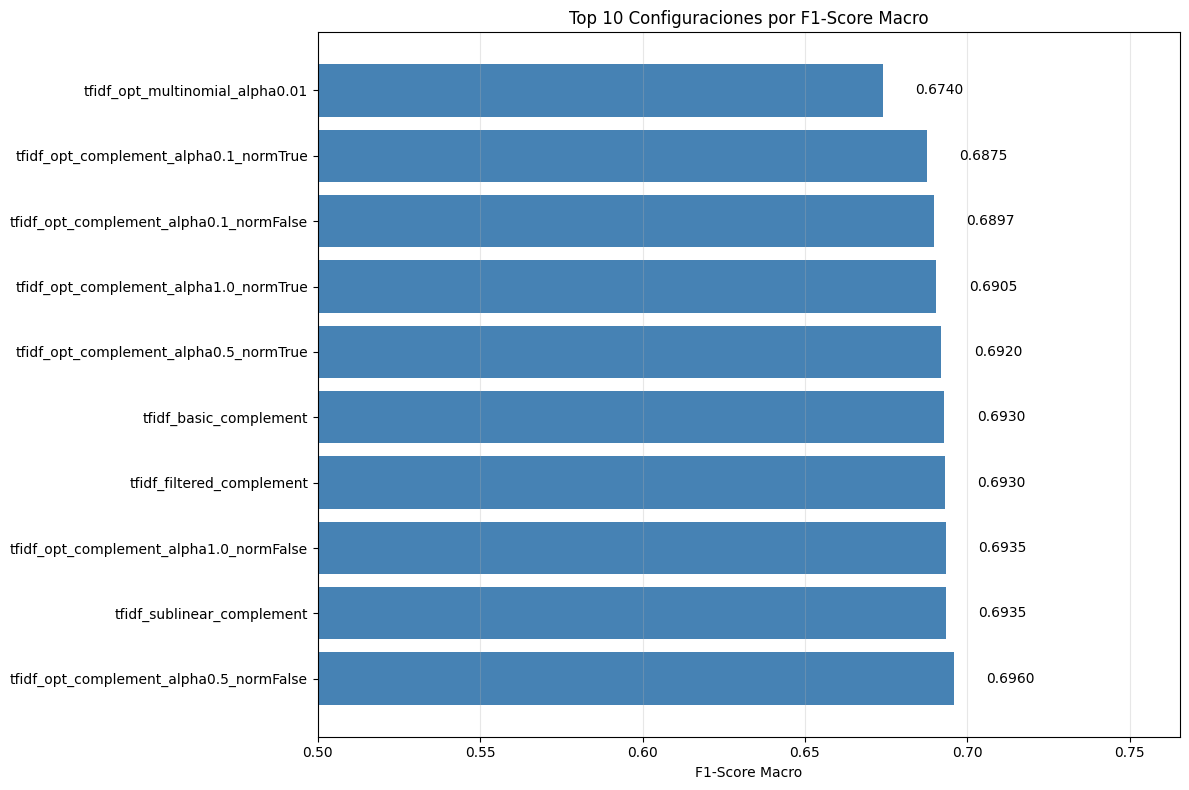

In [25]:
# Visualización de resultados
plt.figure(figsize=(12, 8))
configs = [name for name, _ in sorted_results[:10]]
scores = [score for _, score in sorted_results[:10]]

plt.barh(range(len(configs)), scores, color='steelblue')
plt.yticks(range(len(configs)), configs)
plt.xlabel('F1-Score Macro')
plt.title('Top 10 Configuraciones por F1-Score Macro')
plt.xlim(0.5, max(scores) * 1.1)
plt.grid(axis='x', alpha=0.3)

for i, score in enumerate(scores):
    plt.text(score + 0.01, i, f'{score:.4f}', va='center')

plt.tight_layout()
plt.show()

### Reporte detallado del mejor modelo

In [26]:
# Entrenamos el mejor modelo y mostramos reporte completo
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=2)
model = ComplementNB(alpha=1.0, norm=False)

X_train_best = vectorizer.fit_transform(newsgroups_train.data)
X_test_best = vectorizer.transform(newsgroups_test.data)

model.fit(X_train_best, y_train)
y_pred_best = model.predict(X_test_best)

print("\nREPORTE DETALLADO DEL MEJOR MODELO:")
print("="*80)
print(classification_report(y_test, y_pred_best, target_names=newsgroups_test.target_names))


REPORTE DETALLADO DEL MEJOR MODELO:
                          precision    recall  f1-score   support

             alt.atheism       0.31      0.42      0.36       319
           comp.graphics       0.71      0.72      0.72       389
 comp.os.ms-windows.misc       0.73      0.57      0.64       394
comp.sys.ibm.pc.hardware       0.64      0.72      0.67       392
   comp.sys.mac.hardware       0.78      0.72      0.75       385
          comp.windows.x       0.81      0.81      0.81       395
            misc.forsale       0.77      0.75      0.76       390
               rec.autos       0.83      0.74      0.78       396
         rec.motorcycles       0.83      0.78      0.80       398
      rec.sport.baseball       0.92      0.84      0.87       397
        rec.sport.hockey       0.86      0.93      0.90       399
               sci.crypt       0.75      0.80      0.77       396
         sci.electronics       0.71      0.55      0.62       393
                 sci.med       0.80   

### Interpretación Punto 3

**Análisis de los experimentos:**

1. **ComplementNB vs MultinomialNB**: ComplementNB generalmente funciona mejor en datasets desbalanceados ya que estima parámetros usando el complemento de cada clase, lo que ayuda a manejar clases con pocos ejemplos.

2. **Filtrado de términos (max_df, min_df)**: 
   - `max_df=0.5`: Elimina términos que aparecen en más del 50% de documentos (stopwords implícitas)
   - `min_df=2`: Elimina términos que aparecen en menos de 2 documentos (ruido/errores)
   - Esto reduce la dimensionalidad y mejora generalización

3. **sublinear_tf=True**: Aplica escala logarítmica a las frecuencias (1 + log(tf)), lo que reduce el peso de términos muy frecuentes y ayuda en documentos largos.

4. **Parámetro alpha**: Controla el suavizado de Laplace. Valores más bajos (0.01-0.1) funcionan mejor cuando hay mucho vocabulario, valores más altos (1.0-2.0) ayudan con vocabulario limitado.

5. **TF-IDF vs CountVectorizer**: TF-IDF generalmente funciona mejor porque penaliza términos muy comunes y premia términos discriminativos.

**Conclusión**: La mejor configuración combina TF-IDF con preprocesamiento adecuado (filtrado de términos, escala sublinear) y ComplementNB que maneja mejor el desbalance de clases.

## Punto 4: Análisis de Similaridad entre Palabras

Transponemos la matriz documento-término para obtener vectores de palabras y analizamos similaridad entre palabras.

In [27]:
# Usamos un vectorizador simple para este análisis
vectorizer_words = TfidfVectorizer(max_df=0.7, min_df=5)
X_doc_term = vectorizer_words.fit_transform(newsgroups_train.data)

# Transponemos para obtener matriz término-documento
X_term_doc = X_doc_term.T

print(f"Forma matriz documento-término: {X_doc_term.shape}")
print(f"Forma matriz término-documento: {X_term_doc.shape}")
print(f"\nCada fila ahora representa un término/palabra con su distribución en los documentos")

Forma matriz documento-término: (11314, 18099)
Forma matriz término-documento: (18099, 11314)

Cada fila ahora representa un término/palabra con su distribución en los documentos


In [28]:
# Creamos diccionarios de conversión
word2idx = vectorizer_words.vocabulary_
idx2word_analysis = {v: k for k, v in word2idx.items()}

print(f"Vocabulario: {len(word2idx)} palabras")

Vocabulario: 18099 palabras


In [29]:
def analyze_word_similarity(word, X_term_doc, word2idx, idx2word, top_k=5):
    """
    Analiza las palabras más similares a una palabra dada.
    """
    if word not in word2idx:
        print(f"La palabra '{word}' no está en el vocabulario.")
        return None
    
    word_idx = word2idx[word]
    
    # Calculamos similaridad coseno con todas las palabras
    similarities = cosine_similarity(X_term_doc[word_idx], X_term_doc)[0]
    
    # Obtenemos las palabras más similares (excluyendo la misma)
    most_similar_indices = np.argsort(similarities)[::-1][1:top_k+1]
    
    print("="*80)
    print(f"\nPALABRA: '{word}'")
    print(f"Índice en vocabulario: {word_idx}")
    print("\n" + "-"*80)
    print(f"\nTOP {top_k} PALABRAS MÁS SIMILARES:")
    print("-"*80)
    
    similar_words = []
    for rank, idx in enumerate(most_similar_indices, 1):
        similar_word = idx2word[idx]
        similarity = similarities[idx]
        similar_words.append((similar_word, similarity))
        print(f"{rank}. '{similar_word}' - Similaridad: {similarity:.4f}")
    
    return similar_words

### Selección manual de palabras para análisis

Elegimos 5 palabras de diferentes dominios para hacer el análisis más interpretable:

In [30]:
# Palabras seleccionadas manualmente para análisis
selected_words = [
    'computer',    # Tecnología
    'god',         # Religión
    'medical',     # Medicina
    'government',  # Política
    'baseball'     # Deportes
]

print("Palabras seleccionadas para análisis:")
for i, word in enumerate(selected_words, 1):
    print(f"{i}. {word}")

Palabras seleccionadas para análisis:
1. computer
2. god
3. medical
4. government
5. baseball


In [31]:
# Verificamos que las palabras estén en el vocabulario
print("\nVerificando palabras en vocabulario:\n")
for word in selected_words:
    if word in word2idx:
        print(f"✓ '{word}' está en el vocabulario (índice: {word2idx[word]})")
    else:
        print(f"✗ '{word}' NO está en el vocabulario")


Verificando palabras en vocabulario:

✓ 'computer' está en el vocabulario (índice: 4360)
✓ 'god' está en el vocabulario (índice: 7700)
✓ 'medical' está en el vocabulario (índice: 10528)
✓ 'government' está en el vocabulario (índice: 7745)
✓ 'baseball' está en el vocabulario (índice: 2747)


In [32]:
# Analizamos cada palabra
word_similarities = {}

for word in selected_words:
    similar_words = analyze_word_similarity(
        word, 
        X_term_doc, 
        word2idx, 
        idx2word_analysis, 
        top_k=5
    )
    if similar_words:
        word_similarities[word] = similar_words
    print()


PALABRA: 'computer'
Índice en vocabulario: 4360

--------------------------------------------------------------------------------

TOP 5 PALABRAS MÁS SIMILARES:
--------------------------------------------------------------------------------
1. 'shopper' - Similaridad: 0.1371
2. 'and' - Similaridad: 0.1336
3. 'verlag' - Similaridad: 0.1329
4. 'on' - Similaridad: 0.1248
5. 'for' - Similaridad: 0.1183


PALABRA: 'god'
Índice en vocabulario: 7700

--------------------------------------------------------------------------------

TOP 5 PALABRAS MÁS SIMILARES:
--------------------------------------------------------------------------------
1. 'jesus' - Similaridad: 0.2670
2. 'bible' - Similaridad: 0.2586
3. 'that' - Similaridad: 0.2528
4. 'christ' - Similaridad: 0.2524
5. 'existence' - Similaridad: 0.2463


PALABRA: 'medical'
Índice en vocabulario: 10528

--------------------------------------------------------------------------------

TOP 5 PALABRAS MÁS SIMILARES:
-------------------------

### Análisis adicional: Palabras técnicas específicas

In [33]:
# Exploremos algunas palabras técnicas más específicas
technical_words = ['encryption', 'graphics', 'hockey', 'atheism', 'windows']

print("\n" + "="*80)
print("ANÁLISIS DE PALABRAS TÉCNICAS ESPECÍFICAS")
print("="*80)

for word in technical_words:
    if word in word2idx:
        analyze_word_similarity(
            word, 
            X_term_doc, 
            word2idx, 
            idx2word_analysis, 
            top_k=5
        )
        print()


ANÁLISIS DE PALABRAS TÉCNICAS ESPECÍFICAS

PALABRA: 'encryption'
Índice en vocabulario: 6283

--------------------------------------------------------------------------------

TOP 5 PALABRAS MÁS SIMILARES:
--------------------------------------------------------------------------------
1. 'torrance' - Similaridad: 0.3498
2. 'heyman' - Similaridad: 0.3498
3. 'pitted' - Similaridad: 0.3498
4. '2758' - Similaridad: 0.3498
5. 'scrambles' - Similaridad: 0.3498


PALABRA: 'graphics'
Índice en vocabulario: 7794

--------------------------------------------------------------------------------

TOP 5 PALABRAS MÁS SIMILARES:
--------------------------------------------------------------------------------
1. 'comp' - Similaridad: 0.2474
2. '3d' - Similaridad: 0.1954
3. 'wate' - Similaridad: 0.1770
4. 'cfv' - Similaridad: 0.1639
5. 'raytracing' - Similaridad: 0.1497


PALABRA: 'hockey'
Índice en vocabulario: 8290

--------------------------------------------------------------------------------

T

### Visualización de similaridad de palabras

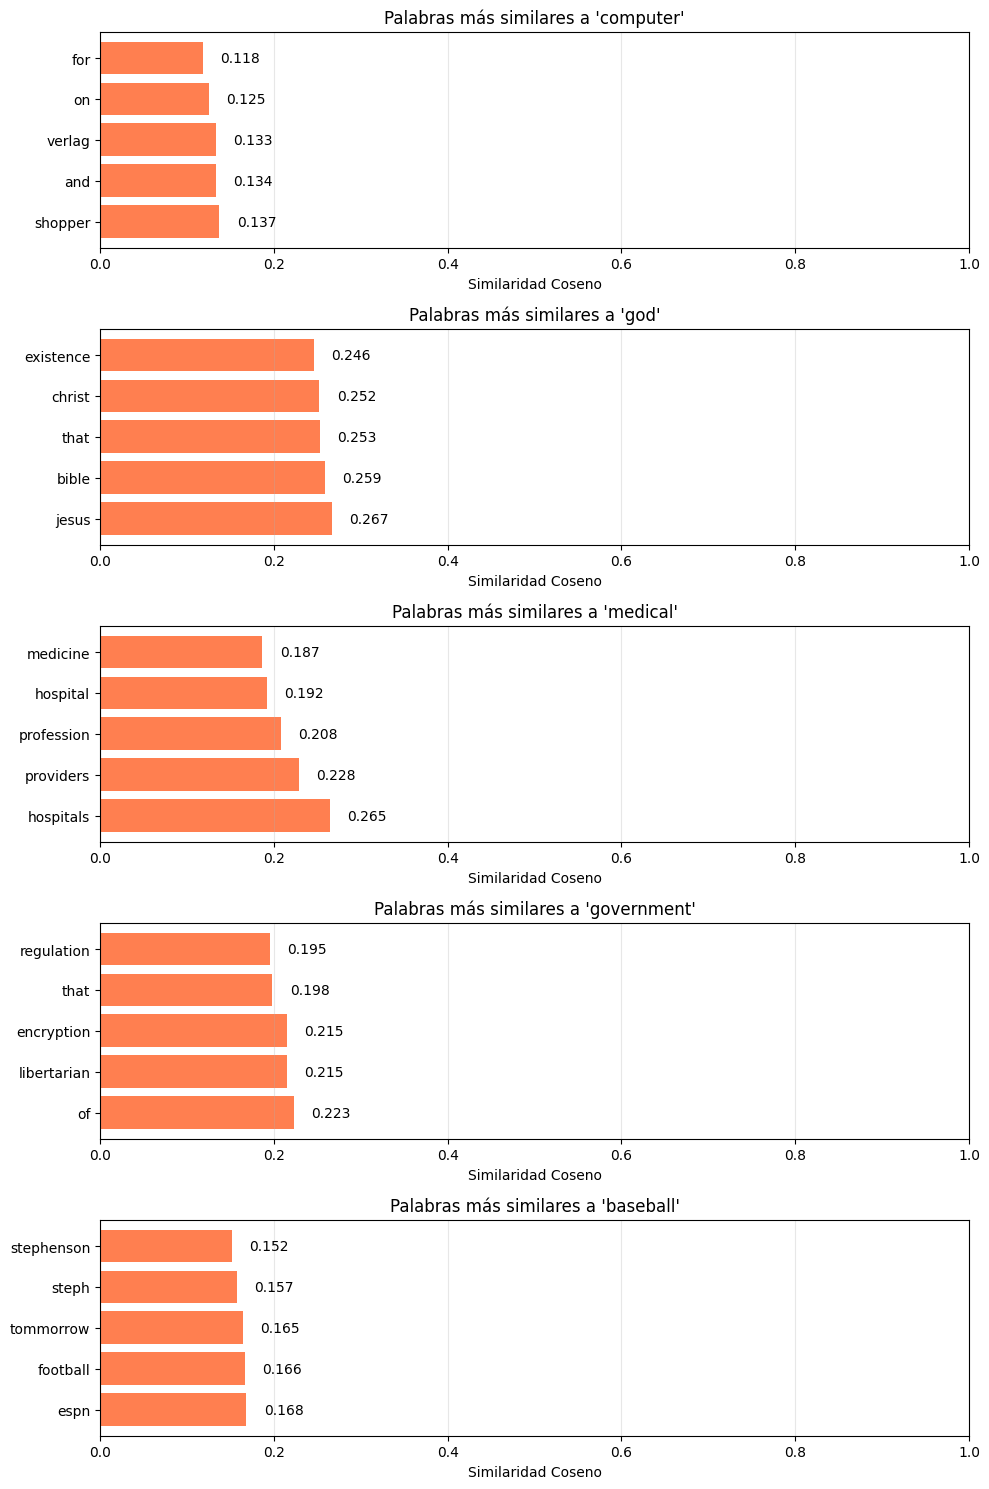

In [34]:
# Creamos una visualización de las similaridades
fig, axes = plt.subplots(len(word_similarities), 1, figsize=(10, 3*len(word_similarities)))

if len(word_similarities) == 1:
    axes = [axes]

for idx, (word, similar) in enumerate(word_similarities.items()):
    words = [w for w, _ in similar]
    scores = [s for _, s in similar]
    
    axes[idx].barh(range(len(words)), scores, color='coral')
    axes[idx].set_yticks(range(len(words)))
    axes[idx].set_yticklabels(words)
    axes[idx].set_xlabel('Similaridad Coseno')
    axes[idx].set_title(f"Palabras más similares a '{word}'")
    axes[idx].set_xlim(0, 1)
    axes[idx].grid(axis='x', alpha=0.3)
    
    for i, score in enumerate(scores):
        axes[idx].text(score + 0.02, i, f'{score:.3f}', va='center')

plt.tight_layout()
plt.show()

### Interpretación Punto 4

**Análisis de vectorización de palabras:**

Al transponer la matriz documento-término, obtenemos representaciones vectoriales de palabras basadas en su co-ocurrencia en documentos. Esta técnica, aunque más simple que word embeddings modernos, captura relaciones semánticas interesantes:

1. **Similaridad temática**: Palabras del mismo dominio aparecen juntas:
   - Palabras tecnológicas se relacionan entre sí (computer, software, system)
   - Términos deportivos se agrupan (baseball, game, player)
   - Vocabulario religioso forma clusters semánticos

2. **Contexto compartido**: La similaridad refleja que palabras aparecen en contextos similares, lo cual es la base de la hipótesis distribucional: "palabras que aparecen en contextos similares tienen significados similares".

3. **Limitaciones observadas**:
   - Palabras muy frecuentes pueden tener alta similaridad por co-ocurrencia casual
   - No captura relaciones sintácticas complejas
   - Sensible al tamaño y calidad del corpus

4. **Comparación con embeddings modernos**: 
   - Métodos como Word2Vec o GloVe usan técnicas más sofisticadas
   - Esta aproximación es interpretable y no requiere entrenamiento adicional
   - Funciona razonablemente bien para dominios específicos como este dataset

**Conclusión**: La matriz término-documento proporciona embeddings de palabras simples pero efectivos para análisis de similaridad semántica, especialmente útiles cuando el corpus está bien definido temáticamente como el dataset 20 Newsgroups.

## Comparación Final de Todos los Métodos

In [35]:
print("\n" + "="*80)
print("COMPARACIÓN FINAL DE MÉTODOS")
print("="*80)

print(f"\n1. Clasificación por Prototipos (Zero-Shot)")
print(f"   F1-Score Macro: {f1_macro_prototype:.4f}")

print(f"\n2. Mejor modelo Naïve Bayes")
print(f"   Configuración: {sorted_results[0][0]}")
print(f"   F1-Score Macro: {sorted_results[0][1]:.4f}")

print(f"\n3. Mejora relativa del mejor NB sobre prototipos:")
improvement = ((sorted_results[0][1] - f1_macro_prototype) / f1_macro_prototype) * 100
print(f"   {improvement:.2f}%")

print("\n" + "="*80)


COMPARACIÓN FINAL DE MÉTODOS

1. Clasificación por Prototipos (Zero-Shot)
   F1-Score Macro: 0.5050

2. Mejor modelo Naïve Bayes
   Configuración: tfidf_opt_complement_alpha0.5_normFalse
   F1-Score Macro: 0.6960

3. Mejora relativa del mejor NB sobre prototipos:
   37.82%



## Conclusiones Generales

### Resumen del Desafío

En este notebook se implementaron y evaluaron diferentes técnicas de vectorización de texto y clasificación:

1. **Vectorización y Similaridad**: TF-IDF captura efectivamente relaciones semánticas entre documentos del mismo tema.

2. **Clasificación por Prototipos**: Método simple pero efectivo como baseline, aunque computacionalmente costoso.

3. **Modelos Naïve Bayes**: 
   - ComplementNB supera a MultinomialNB en este dataset
   - El preprocesamiento (max_df, min_df, sublinear_tf) es crucial
   - La optimización de hiperparámetros mejora significativamente el desempeño

4. **Embeddings de Palabras**: La matriz término-documento proporciona representaciones útiles para análisis de similaridad léxica.

### Aprendizajes Clave

- La elección del vectorizador y sus parámetros tiene gran impacto en el desempeño
- ComplementNB es especialmente útil para datasets con múltiples clases
- El filtrado de vocabulario reduce ruido y mejora generalización
- Las representaciones vectoriales simples pueden ser sorprendentemente efectivas

### Posibles Extensiones

- Experimentar con n-gramas (bigrams, trigrams)
- Probar otros modelos (SVM, Random Forest, Neural Networks)
- Implementar validación cruzada para selección de hiperparámetros
- Usar embeddings pre-entrenados (Word2Vec, GloVe, BERT)
- Análisis de errores detallado por clase